In [89]:
import time

start_time = time.time()

# Task 0 1.
# Implement simple MinHash generator
from sklearn.utils import murmurhash3_32


def hashfunc_gen(i):
    return lambda x: murmurhash3_32(x, seed=i)


def trigrams(string):
    n = len(string)
    if n < 3:
        return set([])
    else:
        trigrams = []
        for i in range(n - 2):
            trigrams.append(string[i:i + 3])
        # print(trigrams)
        return set(trigrams)


def hashcodes_gen(string, m):
    hashcodes = []
    string_trigrams = trigrams(string)
    for i in range(m):
        hashfunc = hashfunc_gen(i)
        minval = float("inf")
        for trigram in string_trigrams:
            val = hashfunc(trigram)
            if val < minval:
                minval = val
                mintri = trigram
        hashcodes.append(mintri)
    return hashcodes


# print(hashcodes_gen("This is a test string. I hope this works?", 100))

# Task 0 2.
s1 = "The mission statement of the WCSCC and area employers recognize the importance of good \
attendance on the job. Any student whose absences exceed 18 days is jeopardizing their opportunity for \
advanced placement as well as hindering his/her likelihood for successfully completing their program."
s2 = "The WCSCC's mission statement and surrounding employers recognize the importance of great \
attendance. Any student who is absent more than 18 days will loose the opportunity for successfully \
completing their trade program."
hash_s1 = hashcodes_gen(s1, 100)
hash_s2 = hashcodes_gen(s2, 100)

# Estimate
equal = 0
for i in range(100):
    if hash_s1[i] == hash_s2[i]:
        equal += 1
print(equal / 100.0)
# Actual

def jaccard(s1, s2):
    return len(set.intersection(trigrams(s1), trigrams(s2))) * 1.0 / len(set.union(trigrams(s1), trigrams(s2)))

print(jaccard(s1, s2))

# Task 0 3.
from collections import defaultdict


class HashTable():
    def __init__(self, k, l, r):
        self.k = k
        self.l = l
        self.r = r
        self.hashtables = [defaultdict(list)] * l
        self.l_hashfuncs = []
        self.kl_hashfuncs = []
        for i in range(l):
            self.l_hashfuncs.append(lambda x: murmurhash3_32(x, seed=i * 2 ** 24) % r)
            k_hashfuncs = []
            for j in range(k):
                k_hashfuncs.append(hashfunc_gen(i * k + j))
            self.kl_hashfuncs.append(k_hashfuncs)

    def insert(self, hashcodes, id):
        for i in range(self.l):
            self.hashtables[i][self.l_hashfuncs[i]("".join(hashcodes[i * self.k: (i + 1) * self.k]))].append(id)

    def lookup(self, hashcodes):
        solution = []
        for i in range(self.l):
            solution.extend(self.hashtables[i][self.l_hashfuncs[i]("".join(hashcodes[i * self.k: (i + 1) * self.k]))])
        return set(solution)

# Import dataset
import csv
import pandas as pd

data = pd.read_csv("../user-ct-test-collection-01.txt", sep="\t")
# urllist = data.ClickURL.dropna().unique()
urllist = np.random.choice(data.ClickURL.dropna().unique(), 50000, replace=False)
k = 2
l = 50
r = 2 ** 20
# r = 2 ** 10

hash_table = HashTable(k, l, r)
url_to_id = {}
for i in range(len(urllist)):
    url = urllist[i]
    url_to_id[url] = i
    hash_table.insert(hashcodes_gen(url, k * l), i)

# print(hash_table.hashtables[0][18])
# print(hash_table.hashtables[0][19])

print("--- %s seconds ---" % (time.time() - start_time))

0.45
0.5228070175438596
--- 77.35434007644653 seconds ---


In [90]:
import random
import numpy as np

In [91]:
# Task 1.
random.seed(24)
sample_200 = np.random.choice(urllist, 200, replace=False)
avg_jaccards = 0
i = 0
start_time = time.time()
for url in sample_200:
    i += 1
    print(i)
    avg_jaccard = 0
    lookup = hash_table.lookup(hashcodes_gen(url, k * l))
    for id_url in lookup:
        avg_jaccard += jaccard(url, urllist[id_url])
    avg_jaccards += avg_jaccard*1.0/len(lookup)
query_time = time.time() - start_time
# Mean Jaccard Similarity
print(avg_jaccards*1.0/200)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
0.2307141872622276


In [92]:
# Total and Average Query Time
print("Total: --- %s seconds ---" % query_time)
print("Average: --- %s seconds ---" % (query_time/200))            

Total: --- 285.2328689098358 seconds ---
Average: --- 1.4261643445491792 seconds ---


In [93]:
# filter lookup so that it only has the top 10 urls in jaccard similarity
avg_jaccards = 0
i = 0
for url in sample_200:
    print(i)
    i += 1
    avg_jaccard = []
    lookup = hash_table.lookup(hashcodes_gen(url, k * l))
    for id_url in lookup:
        avg_jaccard.append(jaccard(url, urllist[id_url]))
    avg_jaccards += sum(sorted(avg_jaccard, reverse=True)[:10])*1.0/10
# Mean Jaccard Similarity Top 10s
print(avg_jaccards*1.0/200)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0.5434357936463445


In [94]:
# Task 2.
avg_jaccards = 0
i = 0
start_time = time.time()
for url in sample_200:
    print(i)
    i += 1
    avg_jaccard = 0
    rest = set(urllist).difference(set([url]))
    for rest_url in rest:
        avg_jaccard += jaccard(url, rest_url)
    avg_jaccards += avg_jaccard*1.0/49999
query_time = time.time() - start_time
# Mean Jaccard Similarity
print(avg_jaccards*1.0/200)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
0.2222445504752399


In [95]:
# Total and Average Query Time
print("Total: --- %s seconds ---" % query_time)
print("Average: --- %s seconds ---" % (query_time/200))            

Total: --- 318.8404641151428 seconds ---
Average: --- 1.594202320575714 seconds ---


In [96]:
# Task 3.
for k in [2, 3, 4, 5, 6]:
    for l in [20, 50, 100]:
        hash_table = HashTable(k, l, r)
        url_to_id = {}
        for i in range(len(urllist)):
            url = urllist[i]
            url_to_id[url] = i
            hash_table.insert(hashcodes_gen(url, k * l), i)

        avg_jaccards = 0
        i = 0
        start_time = time.time()
        for url in sample_200:
            i += 1
            print(i)
            avg_jaccard = 0
            lookup = hash_table.lookup(hashcodes_gen(url, k * l))
            for id_url in lookup:
                avg_jaccard += jaccard(url, urllist[id_url])
            avg_jaccards += avg_jaccard*1.0/len(lookup)
        query_time = time.time() - start_time
        # K and L
        print("K = %s, L = %s" % (k, l))
        # Mean Jaccard Similarity
        print(avg_jaccards*1.0/200)
        print("Average: --- %s seconds ---" % (query_time/200))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
K = 2, L = 20
0.2403597446899761
Average: --- 1.0100414907932282 seconds ---
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
K = 5, L = 50
0.2861309968965132
Average: --- 0.0528190803527832 seconds ---
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
K = 5, L = 100
0.27197386388958117
Aver

In [97]:
import matplotlib.pyplot as plt
def s_curve(ls, ks):
    curves = []
    legend = []
    for l in ls:
        for k in ks:
            legend.append("K = " + str(k) + ", L = " + str(l))
            curve = []
            for j in np.arange(0, 1, 0.01):
                curve.append(1 - (1 - j**k)**l)
            curves.append(curve)
            
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    plt.figure()
    for i in range(len(curves)):
        plt.plot(np.arange(0, 1, 0.01), curves[i], colors[i])
    plt.title("S Curves")
    plt.xlabel("Jaccard Similarity")
    plt.ylabel("Probability of Retrieving")
    plt.legend(legend, loc="lower right")
    plt.show()

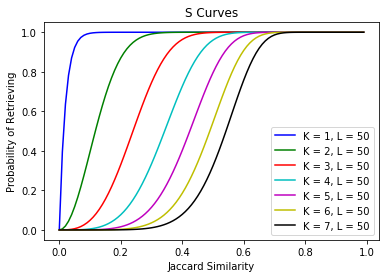

In [98]:
s_curve([50], [1,2,3,4,5,6,7])

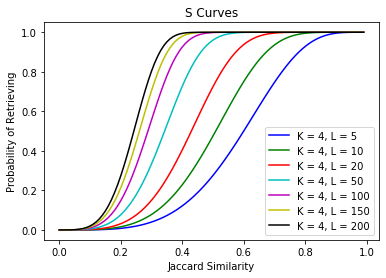

In [99]:
s_curve([5,10,20,50,100,150,200], [4])